# 1. Import Required Libraries

In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json
from itertools import product
import optuna
import time

warnings.filterwarnings("ignore")

# 2. Define Global Variables

In [88]:
SEQUENCE_LENGTH = 12  # 12 months lookback
MODEL_DIR = 'cinnamon_models/Quillings' # Directory to save models and preprocessors

# Create model directory
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created model directory: {MODEL_DIR}")

# Initialize preprocessors
scaler_features = StandardScaler()
scaler_target = StandardScaler()
label_encoders = {}

# 3. Data Loading and Preparation

In [89]:
def load_and_prepare_data(data_path):
    """Load and prepare the cinnamon price dataset"""
    print(f"Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Rename 'Date' to 'Month' and 'Price' to 'Regional_Price' for consistency
    if 'Date' in df.columns:
        df = df.rename(columns={'Date': 'Month'})
    if 'Price' in df.columns:
        df = df.rename(columns={'Price': 'Regional_Price'})

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Create National_Price as average of all regional prices for each date and grade
    national_avg = df.groupby(['Month', 'Grade'])['Regional_Price'].mean().reset_index()
    national_avg = national_avg.rename(columns={'Regional_Price': 'National_Price'})
    df = df.merge(national_avg, on=['Month', 'Grade'], how='left')

    # Create Is_Active_Region (all regions are active in this dataset)
    df['Is_Active_Region'] = 1

    # Encode categorical variables
    for col in ['Grade', 'Region']:
        if col not in label_encoders:
            label_encoders[col] = LabelEncoder()
        df[f'{col}_encoded'] = label_encoders[col].fit_transform(df[col])

    # Create time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Sort data
    df = df.sort_values(['Grade', 'Region', 'Month'])
    
    # Create lag features
    lag_columns = ['Regional_Price', 'Temperature', 'Rainfall']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    for col in ['Regional_Price', 'Temperature', 'Rainfall']:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    print(f"Unique grades: {df['Grade'].unique()}")
    print(f"Unique regions: {df['Region'].unique()}")

    return df

# 4. Visualization Functions

In [90]:
def plot_price_distribution_by_grade(df):
    """Plot price distribution by grade"""
    df_clean = df.dropna(subset=['Regional_Price'])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Box plot
    sns.boxplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax1)
    ax1.set_title('Price Distribution by Grade (Box Plot)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Grade', fontsize=12)
    ax1.set_ylabel('Regional Price', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Violin plot
    sns.violinplot(data=df_clean, x='Grade', y='Regional_Price', ax=ax2)
    ax2.set_title('Price Distribution by Grade (Violin Plot)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Grade', fontsize=12)
    ax2.set_ylabel('Regional Price', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    # Mean prices with error bars
    grade_stats = df_clean.groupby('Grade')['Regional_Price'].agg(['mean', 'std', 'count']).reset_index()
    grade_stats['se'] = grade_stats['std'] / np.sqrt(grade_stats['count'])
    
    ax3.bar(grade_stats['Grade'], grade_stats['mean'], 
            yerr=grade_stats['se'], capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax3.set_title('Average Price by Grade (with Standard Error)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Grade', fontsize=12)
    ax3.set_ylabel('Average Regional Price', fontsize=12)
    ax3.tick_params(axis='x', rotation=45)
    
    for i, (grade, mean_price) in enumerate(zip(grade_stats['Grade'], grade_stats['mean'])):
        ax3.text(i, mean_price + grade_stats['se'].iloc[i], f'{mean_price:.1f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # Histogram
    for grade in df_clean['Grade'].unique():
        grade_data = df_clean[df_clean['Grade'] == grade]['Regional_Price']
        ax4.hist(grade_data, alpha=0.6, label=grade, bins=20, density=True)
    
    ax4.set_title('Price Distribution Histograms by Grade', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Regional Price', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nPrice Distribution Summary by Grade:")
    print("=" * 50)
    summary_stats = df_clean.groupby('Grade')['Regional_Price'].describe()
    print(summary_stats.round(2))


def plot_feature_correlation_matrix(df):
    """Plot feature correlation matrix"""
    numeric_features = [
        'Regional_Price', 'Seasonal_Impact',
        'Local_Production_Volume', 'Local_Export_Volume',
        'Global_Production_Volume', 'Global_Consumption_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate',
        'Fuel_Price', 'Year', 'Month_num', 'Quarter', 'Grade_encoded',
        'Region_encoded'
    ]
    
    available_features = [col for col in numeric_features if col in df.columns]
    df_numeric = df[available_features].select_dtypes(include=[np.number])
    correlation_matrix = df_numeric.corr()
    
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={'label': 'Correlation Coefficient'},
                annot_kws={'size': 8})
    
    plt.title('Feature Correlation Matrix\n(Cinnamon Price Forecasting Dataset)', 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.7):")
    print("=" * 60)
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs.append((
                    correlation_matrix.columns[i], 
                    correlation_matrix.columns[j], 
                    corr_val
                ))
    
    if high_corr_pairs:
        for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"{feature1} ↔ {feature2}: {corr:.3f}")
    else:
        print("No feature pairs with |correlation| > 0.7 found.")

# 5. Sequence Peparation

In [91]:
def prepare_sequences(df, sequence_length=12, target_col='Regional_Price'):
    """Create sequences for LSTM training"""
    feature_cols = [
        'Grade_encoded', 'Region_encoded',
        'Seasonal_Impact', 'Local_Production_Volume',
        'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
        'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
        'Year', 'Month_num', 'Quarter'
    ]

    # Add lag and rolling features
    lag_cols = [col for col in df.columns if 'lag_' in col or 'rolling_' in col]
    feature_cols.extend(lag_cols)

    # Fill NaN values
    df_clean = df.copy()
    df_clean = df_clean.fillna(method='bfill').fillna(method='ffill')

    X_sequences, y_sequences, metadata = [], [], []

    for grade in df_clean['Grade'].unique():
        for region in df_clean['Region'].unique():
            subset = df_clean[(df_clean['Grade'] == grade) & (df_clean['Region'] == region)].sort_values('Month')

            if len(subset) < sequence_length + 1:
                continue

            for i in range(len(subset) - sequence_length):
                X_seq = subset.iloc[i:i + sequence_length][feature_cols].values
                y_seq = subset.iloc[i + sequence_length][target_col]

                X_sequences.append(X_seq)
                y_sequences.append(y_seq)
                metadata.append({
                    'grade': grade,
                    'region': region,
                    'date': subset.iloc[i + sequence_length]['Month']
                })

    print(f"Total sequences created: {len(X_sequences)}")
    return np.array(X_sequences), np.array(y_sequences), metadata

# 6. Model Building

In [92]:
def build_lstm_model_tunable(units1=128, units2=64, dropout1=0.2, dropout2=0.2, 
                            dense_units=32, optimizer='adam', learning_rate=0.001, 
                            layer_type='LSTM', use_batch_norm=False, input_shape=None):
    """Build tunable LSTM model"""
    model = Sequential()
    
    # First RNN layer
    if layer_type == 'LSTM':
        model.add(LSTM(units1, return_sequences=True, input_shape=input_shape))
    elif layer_type == 'GRU':
        model.add(GRU(units1, return_sequences=True, input_shape=input_shape))
    else:
        model.add(SimpleRNN(units1, return_sequences=True, input_shape=input_shape))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout1))
    
    # Second RNN layer
    if layer_type == 'LSTM':
        model.add(LSTM(units2, return_sequences=False))
    elif layer_type == 'GRU':
        model.add(GRU(units2, return_sequences=False))
    else:
        model.add(SimpleRNN(units2, return_sequences=False))
    
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout2))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(1))
    
    # Configure optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    return model

# 7. Hyperparameter Tuning

In [93]:
class HyperparameterTuner:
    """Hyperparameter tuning class"""
    
    def __init__(self, X_train, y_train, X_val, y_val, input_shape):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.input_shape = input_shape
        self.best_params = None
        self.best_score = float('inf')
        self.tuning_results = []
    
    def optuna_tuning(self, n_trials=50):
        """Optuna-based hyperparameter tuning"""
        print("\n🎯 Starting Optuna Hyperparameter Tuning...")
        print("=" * 60)
        
        def objective(trial):
            params = {
                'units1': trial.suggest_categorical('units1', [64, 128, 256, 512]),
                'units2': trial.suggest_categorical('units2', [32, 64, 128, 256]),
                'dropout1': trial.suggest_float('dropout1', 0.1, 0.5, step=0.1),
                'dropout2': trial.suggest_float('dropout2', 0.1, 0.5, step=0.1),
                'dense_units': trial.suggest_categorical('dense_units', [16, 32, 64, 128]),
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
                'layer_type': trial.suggest_categorical('layer_type', ['LSTM', 'GRU']),
                'use_batch_norm': trial.suggest_categorical('use_batch_norm', [True, False]),
                'optimizer': trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
            }
            
            try:
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                del model
                tf.keras.backend.clear_session()
                
                return val_loss
                
            except Exception as e:
                print(f"Trial failed: {e}")
                return float('inf')
        
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        self.best_params = study.best_params
        self.best_score = study.best_value
        
        print(f"\n🎉 Optuna Tuning Complete!")
        print(f"Best validation loss: {study.best_value:.6f}")
        print(f"Best parameters: {study.best_params}")
        
        return study.best_params, study.best_value
    
    def random_search_tuning(self, n_trials=30):
        """Random search hyperparameter tuning"""
        print("\n🎲 Starting Random Search Hyperparameter Tuning...")
        print("=" * 60)
        
        best_val_loss = float('inf')
        best_params = None
        
        for i in range(n_trials):
            params = {
                'units1': int(np.random.choice([64, 128, 256, 512])),
                'units2': int(np.random.choice([32, 64, 128, 256])),
                'dropout1': float(np.random.uniform(0.1, 0.5)),
                'dropout2': float(np.random.uniform(0.1, 0.5)),
                'dense_units': int(np.random.choice([16, 32, 64, 128])),
                'learning_rate': float(10 ** np.random.uniform(-4, -2)),
                'layer_type': str(np.random.choice(['LSTM', 'GRU'])),
                'use_batch_norm': bool(np.random.choice([True, False])),
                'optimizer': str(np.random.choice(['adam', 'rmsprop']))
            }
            
            try:
                print(f"\nTrial {i+1}/{n_trials}")
                
                model = build_lstm_model_tunable(**params, input_shape=self.input_shape)
                
                history = model.fit(
                    self.X_train, self.y_train,
                    validation_data=(self.X_val, self.y_val),
                    epochs=25,
                    batch_size=32,
                    verbose=0,
                    callbacks=[
                        EarlyStopping(patience=5, restore_best_weights=True),
                        ReduceLROnPlateau(patience=3, factor=0.5, verbose=0)
                    ]
                )
                
                val_loss = min(history.history['val_loss'])
                
                result = {
                    'trial': i+1,
                    'params': params.copy(),
                    'val_loss': val_loss,
                    'val_mae': min(history.history['val_mae'])
                }
                
                self.tuning_results.append(result)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = params.copy()
                    print(f"✅ New best validation loss: {val_loss:.6f}")
                else:
                    print(f"   Validation loss: {val_loss:.6f}")
                
                del model
                tf.keras.backend.clear_session()
                
            except Exception as e:
                print(f"❌ Trial {i+1} failed: {e}")
                continue
        
        self.best_params = best_params
        self.best_score = best_val_loss
        
        print(f"\n🎉 Random Search Complete!")
        print(f"Best validation loss: {best_val_loss:.6f}")
        print(f"Best parameters: {best_params}")
        
        return best_params, best_val_loss


def perform_hyperparameter_tuning(X_train, y_train, X_val, y_val, input_shape, 
                                 method='optuna', n_trials=30):
    """Main function to perform hyperparameter tuning"""
    print(f"\n🚀 Starting Hyperparameter Tuning using {method.upper()} method...")
    
    tuner = HyperparameterTuner(X_train, y_train, X_val, y_val, input_shape)
    
    if method == 'optuna':
        best_params, best_score = tuner.optuna_tuning(n_trials=n_trials)
    elif method == 'random':
        best_params, best_score = tuner.random_search_tuning(n_trials=n_trials)
    else:
        raise ValueError("Method must be 'optuna' or 'random'")
    
    return best_params, best_score, tuner

# 8. Model Training

In [94]:
def build_lstm_model(input_shape, best_params=None):
    """Build LSTM model with optional best parameters"""
    if best_params is None:
        best_params = {
            'units1': 128,
            'units2': 64,
            'dropout1': 0.2,
            'dropout2': 0.2,
            'dense_units': 32,
            'optimizer': 'adam',
            'learning_rate': 0.001,
            'layer_type': 'LSTM',
            'use_batch_norm': False
        }
    
    return build_lstm_model_tunable(**best_params, input_shape=input_shape)


def plot_training_history(history):
    """Plot training vs validation loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss (MSE)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2, color='blue')
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='red')
    ax2.set_title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MAE', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_mae = history.history['mae'][-1]
    final_val_mae = history.history['val_mae'][-1]
    
    print(f"\nFinal Training Metrics:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Training MAE: {final_train_mae:.4f}")
    print(f"Validation MAE: {final_val_mae:.4f}")


def train_model(df, use_tuning=True, tuning_method='optuna', n_tuning_trials=20):
    """Train the forecasting model with optional hyperparameter tuning"""
    global scaler_features, scaler_target
    
    print("Preparing sequences...")
    X, y, metadata = prepare_sequences(df, SEQUENCE_LENGTH)

    if len(X) == 0:
        raise ValueError("No sequences could be created. Check if there's enough data.")

    print(f"Created {len(X)} sequences with shape {X.shape}")

    # Scale features and target
    print("Scaling features...")
    n_samples, n_timesteps, n_features = X.shape
    X_reshaped = X.reshape(-1, n_features)
    X_scaled_reshaped = scaler_features.fit_transform(X_reshaped)
    X_scaled = X_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

    y_scaled = scaler_target.fit_transform(y.reshape(-1, 1)).flatten()

    # Train-validation-test split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42
    )

    print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
    print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

    input_shape = (X_train.shape[1], X_train.shape[2])
    best_params = None
    tuner = None
    
    # Hyperparameter tuning
    if use_tuning:
        print(f"\n🔧 Performing hyperparameter tuning using {tuning_method} method...")
        best_params, best_score, tuner = perform_hyperparameter_tuning(
            X_train, y_train, X_val, y_val, input_shape, 
            method=tuning_method, n_trials=n_tuning_trials
        )
        
        print(f"\n📊 Hyperparameter Tuning Results:")
        print(f"Best validation loss: {best_score:.6f}")
        print(f"Best parameters:")
        for key, value in best_params.items():
            print(f"  {key}: {value}")
    else:
        print("\nSkipping hyperparameter tuning, using default parameters...")

    # Build and train final model
    print("\nBuilding final model with optimized parameters...")
    model = build_lstm_model(input_shape, best_params)
    
    print("\n📋 Final Model Architecture:")
    model.summary()

    print("\nTraining final model...")
    final_epochs = 150 if use_tuning else 100
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=final_epochs,
        batch_size=32,
        verbose=1,
        callbacks=[
            EarlyStopping(patience=15, restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(patience=8, factor=0.5, verbose=1)
        ]
    )

    plot_training_history(history)

    # Evaluate on test set
    print("\nEvaluating final model on test set...")
    y_pred = model.predict(X_test)
    y_pred_unscaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    r2 = r2_score(y_test_unscaled, y_pred_unscaled)

    print(f"\n🎯 Final Model Performance on Test Set:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    
    results = {
        'mae': mae, 
        'rmse': rmse, 
        'r2': r2,
        'best_params': best_params,
        'tuning_method': tuning_method if use_tuning else None,
        'tuning_used': use_tuning,
        'epochs_trained': len(history.history['loss']),
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1]
    }
    
    if tuner and hasattr(tuner, 'tuning_results'):
        results['tuning_results'] = tuner.tuning_results
    
    return model, history, results

# 9. Model Saving

In [95]:
def save_model(model, metrics, model_dir=MODEL_DIR):
    """Save the trained model and preprocessors"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_save_dir = os.path.join(model_dir, f"cinnamon_model_{timestamp}")
    os.makedirs(model_save_dir, exist_ok=True)
    
    print(f"\n💾 Saving model to: {model_save_dir}")
    
    try:
        # Save Keras model
        model_path = os.path.join(model_save_dir, "lstm_model.keras")
        model.save(model_path)
        print(f"✅ Keras model saved: lstm_model.keras")
        
        # Save scalers
        scalers_path = os.path.join(model_save_dir, "scalers.pkl")
        scalers = {
            'scaler_features': scaler_features,
            'scaler_target': scaler_target
        }
        with open(scalers_path, 'wb') as f:
            pickle.dump(scalers, f)
        print(f"✅ Scalers saved: scalers.pkl")
        
        # Save label encoders
        encoders_path = os.path.join(model_save_dir, "label_encoders.pkl")
        with open(encoders_path, 'wb') as f:
            pickle.dump(label_encoders, f)
        print(f"✅ Label encoders saved: label_encoders.pkl")
        
        # Save model configuration
        config = {
            'sequence_length': SEQUENCE_LENGTH,
            'model_architecture': {
                'input_shape': model.input_shape,
                'layers': [str(layer.__class__.__name__) for layer in model.layers],
                'total_params': model.count_params()
            },
            'training_info': {
                'timestamp': timestamp,
                'mae': float(metrics['mae']),
                'rmse': float(metrics['rmse']),
                'r2': float(metrics['r2']),
                'tuning_used': metrics.get('tuning_used', False),
                'tuning_method': metrics.get('tuning_method', None),
                'best_params': metrics.get('best_params', None),
                'epochs_trained': metrics.get('epochs_trained', 0),
                'final_train_loss': float(metrics.get('final_train_loss', 0)),
                'final_val_loss': float(metrics.get('final_val_loss', 0))
            }
        }
        
        if 'tuning_results' in metrics and metrics['tuning_results']:
            tuning_results_path = os.path.join(model_save_dir, "tuning_results.json")
            with open(tuning_results_path, 'w') as f:
                json.dump(metrics['tuning_results'], f, indent=2, default=str)
            print(f"✅ Hyperparameter tuning results saved: tuning_results.json")
        
        config_path = os.path.join(model_save_dir, "model_config.json")
        with open(config_path, 'w') as f:
            json.dump(config, f, indent=2, default=str)
        print(f"✅ Model configuration saved: model_config.json")
        
        print(f"\n🎉 Model successfully saved to: {model_save_dir}")
        print(f"\n📊 Saved Model Summary:")
        print(f"  • Performance: MAE={metrics['mae']:.2f}, RMSE={metrics['rmse']:.2f}, R²={metrics['r2']:.4f}")
        if metrics.get('tuning_used'):
            print(f"  • Hyperparameter tuning: {metrics['tuning_method']} method used")
            print(f"  • Best parameters found and applied")
        print(f"  • Training epochs: {metrics.get('epochs_trained', 'N/A')}")
        print(f"  • Total parameters: {model.count_params():,}")
        
        return model_save_dir
        
    except Exception as e:
        print(f"❌ Error saving model: {str(e)}")
        return None


def load_saved_model(model_path):
    """Load a previously saved model"""
    global scaler_features, scaler_target, label_encoders
    
    print(f"📂 Loading model from: {model_path}")
    
    try:
        # Load Keras model
        keras_model_path = os.path.join(model_path, "lstm_model.keras")
        model = load_model(keras_model_path)
        print(f"✅ Keras model loaded")
        
        # Load scalers
        scalers_path = os.path.join(model_path, "scalers.pkl")
        with open(scalers_path, 'rb') as f:
            scalers = pickle.load(f)
        scaler_features = scalers['scaler_features']
        scaler_target = scalers['scaler_target']
        print(f"✅ Scalers loaded")
        
        # Load label encoders
        encoders_path = os.path.join(model_path, "label_encoders.pkl")
        with open(encoders_path, 'rb') as f:
            label_encoders = pickle.load(f)
        print(f"✅ Label encoders loaded")
        
        # Load configuration
        config_path = os.path.join(model_path, "model_config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        print(f"🎉 Model successfully loaded!")
        print(f"📊 Performance: MAE={config['training_info']['mae']:.2f}, "
              f"RMSE={config['training_info']['rmse']:.2f}, "
              f"R²={config['training_info']['r2']:.4f}")
        
        if config['training_info'].get('tuning_used'):
            print(f"🔧 This model was trained with {config['training_info']['tuning_method']} hyperparameter tuning")
        
        return model, config
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None

# 10. Forecasting Functions

In [96]:
TRAIN_FEATURE_COLS = [
    'Grade_encoded', 'Region_encoded',
    'Seasonal_Impact', 'Local_Production_Volume',
    'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
    'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
    'Year', 'Month_num', 'Quarter',
    'Regional_Price_lag_1', 'Regional_Price_lag_3', 'Regional_Price_lag_6', 'Regional_Price_lag_12',
    'Temperature_lag_1', 'Temperature_lag_3', 'Temperature_lag_6', 'Temperature_lag_12',
    'Rainfall_lag_1', 'Rainfall_lag_3', 'Rainfall_lag_6', 'Rainfall_lag_12',
    'Regional_Price_rolling_3', 'Regional_Price_rolling_6', 'Regional_Price_rolling_12',
    'Temperature_rolling_3', 'Temperature_rolling_6', 'Temperature_rolling_12',
    'Rainfall_rolling_3', 'Rainfall_rolling_6', 'Rainfall_rolling_12'
]


def forecast_prices(model, df, grade, region, months_ahead=12):
    """Generate price forecasts"""
    subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
    last_row = subset.iloc[-1]
    last_date = last_row['Month']

    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                 periods=months_ahead, freq='MS')
    
    # Generate future rows
    future_rows = []
    for future_date in future_dates:
        row = last_row.copy()
        row['Month'] = future_date
        row['Year'] = future_date.year
        row['Month_num'] = future_date.month
        row['Quarter'] = future_date.quarter
        row['Temperature'] = last_row['Temperature'] + 2 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,0.5)
        row['Rainfall'] = max(0, last_row['Rainfall'] + 20 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,10))
        row['Exchange_Rate'] = last_row['Exchange_Rate'] * (1 + np.random.normal(0.001,0.005))
        row['Inflation_Rate'] = last_row['Inflation_Rate'] + np.random.normal(0,0.1)
        row['Fuel_Price'] = last_row['Fuel_Price'] * (1 + np.random.normal(0.002,0.02))
        future_rows.append(row)

    future_df = pd.DataFrame(future_rows)
    extended_df = pd.concat([subset, future_df], ignore_index=True).sort_values('Month')

    # Recreate lag and rolling features
    for col in ['Regional_Price','National_Price','Temperature','Rainfall']:
        for lag in [1,3,6,12]:
            extended_df[f'{col}_lag_{lag}'] = extended_df.groupby(['Grade','Region'])[col].shift(lag)
        for window in [3,6,12]:
            extended_df[f'{col}_rolling_{window}'] = extended_df.groupby(['Grade','Region'])[col].transform(lambda x: x.rolling(window).mean())

    feature_cols = [c for c in TRAIN_FEATURE_COLS if c in extended_df.columns]

    forecasts = []
    historical_data = extended_df[extended_df['Month'] <= last_date]

    for i in range(months_ahead):
        current_data = extended_df.iloc[len(historical_data)-SEQUENCE_LENGTH+i : len(historical_data)+i]
        if len(current_data) < SEQUENCE_LENGTH:
            padding_needed = SEQUENCE_LENGTH - len(current_data)
            last_known = historical_data.iloc[-1:].copy()
            padding_data = pd.concat([last_known]*padding_needed, ignore_index=True)
            current_data = pd.concat([padding_data, current_data], ignore_index=True).iloc[-SEQUENCE_LENGTH:]

        sequence = current_data[feature_cols].ffill().bfill().values
        sequence_flat = sequence.reshape(-1, sequence.shape[-1])
        sequence_scaled_flat = scaler_features.transform(sequence_flat)
        sequence_scaled = sequence_scaled_flat.reshape(sequence.shape)

        next_pred = model.predict(sequence_scaled.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)
        next_pred_unscaled = scaler_target.inverse_transform(next_pred)[0][0]
        forecasts.append(next_pred_unscaled)

        future_idx = len(historical_data)+i
        extended_df.iloc[future_idx, extended_df.columns.get_loc('Regional_Price')] = next_pred_unscaled
        extended_df.iloc[future_idx, extended_df.columns.get_loc('National_Price')] = next_pred_unscaled

    return forecasts, future_dates


def plot_forecast_results(df, model, grade, region, months_ahead=12):
    """Plot historical data with forecast results"""
    try:
        subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
        
        if len(subset) == 0:
            print(f"No data found for {grade} in {region}")
            return None, None
        
        forecasts, future_dates = forecast_prices(model, df, grade, region, months_ahead)
        
        plt.figure(figsize=(16, 8))
        
        # Plot historical data
        plt.plot(subset['Month'], subset['Regional_Price'], 
                label='Historical Prices', linewidth=2, color='blue', marker='o', markersize=4)
        
        # Bridge connection
        last_historical_date = subset['Month'].iloc[-1]
        last_historical_price = subset['Regional_Price'].iloc[-1]
        first_forecast_date = future_dates[0]
        first_forecast_price = forecasts[0]
        
        plt.plot([last_historical_date, first_forecast_date], 
                [last_historical_price, first_forecast_price], 
                color='orange', linewidth=2, linestyle='-', alpha=0.8, 
                label='Historical-Forecast Bridge')
        
        # Plot forecasts
        extended_forecast_dates = [last_historical_date] + list(future_dates)
        extended_forecasts = [last_historical_price] + list(forecasts)
        
        plt.plot(extended_forecast_dates, extended_forecasts, 
                label='Forecasted Prices', linewidth=2, color='red', 
                marker='s', markersize=5, linestyle='--', alpha=0.9)
        
        plt.axvline(x=last_historical_date, color='blue', linestyle=':', alpha=0.5, linewidth=1, 
                   label='Forecast Start')
        
        plt.title(f'Cinnamon Price Forecast: {grade.title()} Grade in {region.title()}\n'
                 f'Historical Data vs {months_ahead}-Month Forecast', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Regional Price', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        # Confidence bands
        if len(forecasts) > 1:
            forecast_std = np.std(subset['Regional_Price'].tail(12))
            upper_bound = np.array(extended_forecasts[1:]) + 1.96 * forecast_std
            lower_bound = np.array(extended_forecasts[1:]) - 1.96 * forecast_std
            
            plt.fill_between(future_dates, lower_bound, upper_bound, 
                           alpha=0.2, color='red', label='95% Confidence Interval')
        
        plt.tight_layout()
        plt.show()
        
        # Print forecast summary
        print(f"\n{grade.title()} Grade Forecast for {region.title()}:")
        print("=" * 50)
        for i, (date, price) in enumerate(zip(future_dates, forecasts), 1):
            print(f"Month {i:2d} ({date.strftime('%Y-%m')}): LKR {price:8.2f}")
        
        print(f"\nForecast Statistics:")
        print(f"Average Forecast Price: LKR {np.mean(forecasts):.2f}")
        print(f"Price Range: LKR {np.min(forecasts):.2f} - LKR {np.max(forecasts):.2f}")
        
        if len(forecasts) > 1:
            trend = (forecasts[-1] - forecasts[0]) / len(forecasts)
            trend_direction = "increasing" if trend > 0 else "decreasing"
            print(f"Overall Trend: {trend_direction} by LKR {abs(trend):.2f} per month")
        
        return forecasts, future_dates
        
    except Exception as e:
        print(f"Error plotting forecast results: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# 11. Main Execution

🚀 CINNAMON PRICE FORECASTING WITH LSTM

📊 Step 1: Loading and preparing data...
Loading data from C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Quillings_Dataset.csv...
Initial data shape: (414, 14)
Columns: ['Month', 'Grade', 'Region', 'Regional_Price', 'Seasonal_Impact', 'Local_Production_Volume', 'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume', 'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price']
Creating lag and rolling features...
Final data shape after feature engineering: (414, 42)
Unique grades: ['G1' 'G2']
Unique regions: ['Central' 'Down_South' 'Uva']
✅ Data loaded successfully! Shape: (414, 42)

📈 Step 2: Generating visualizations...


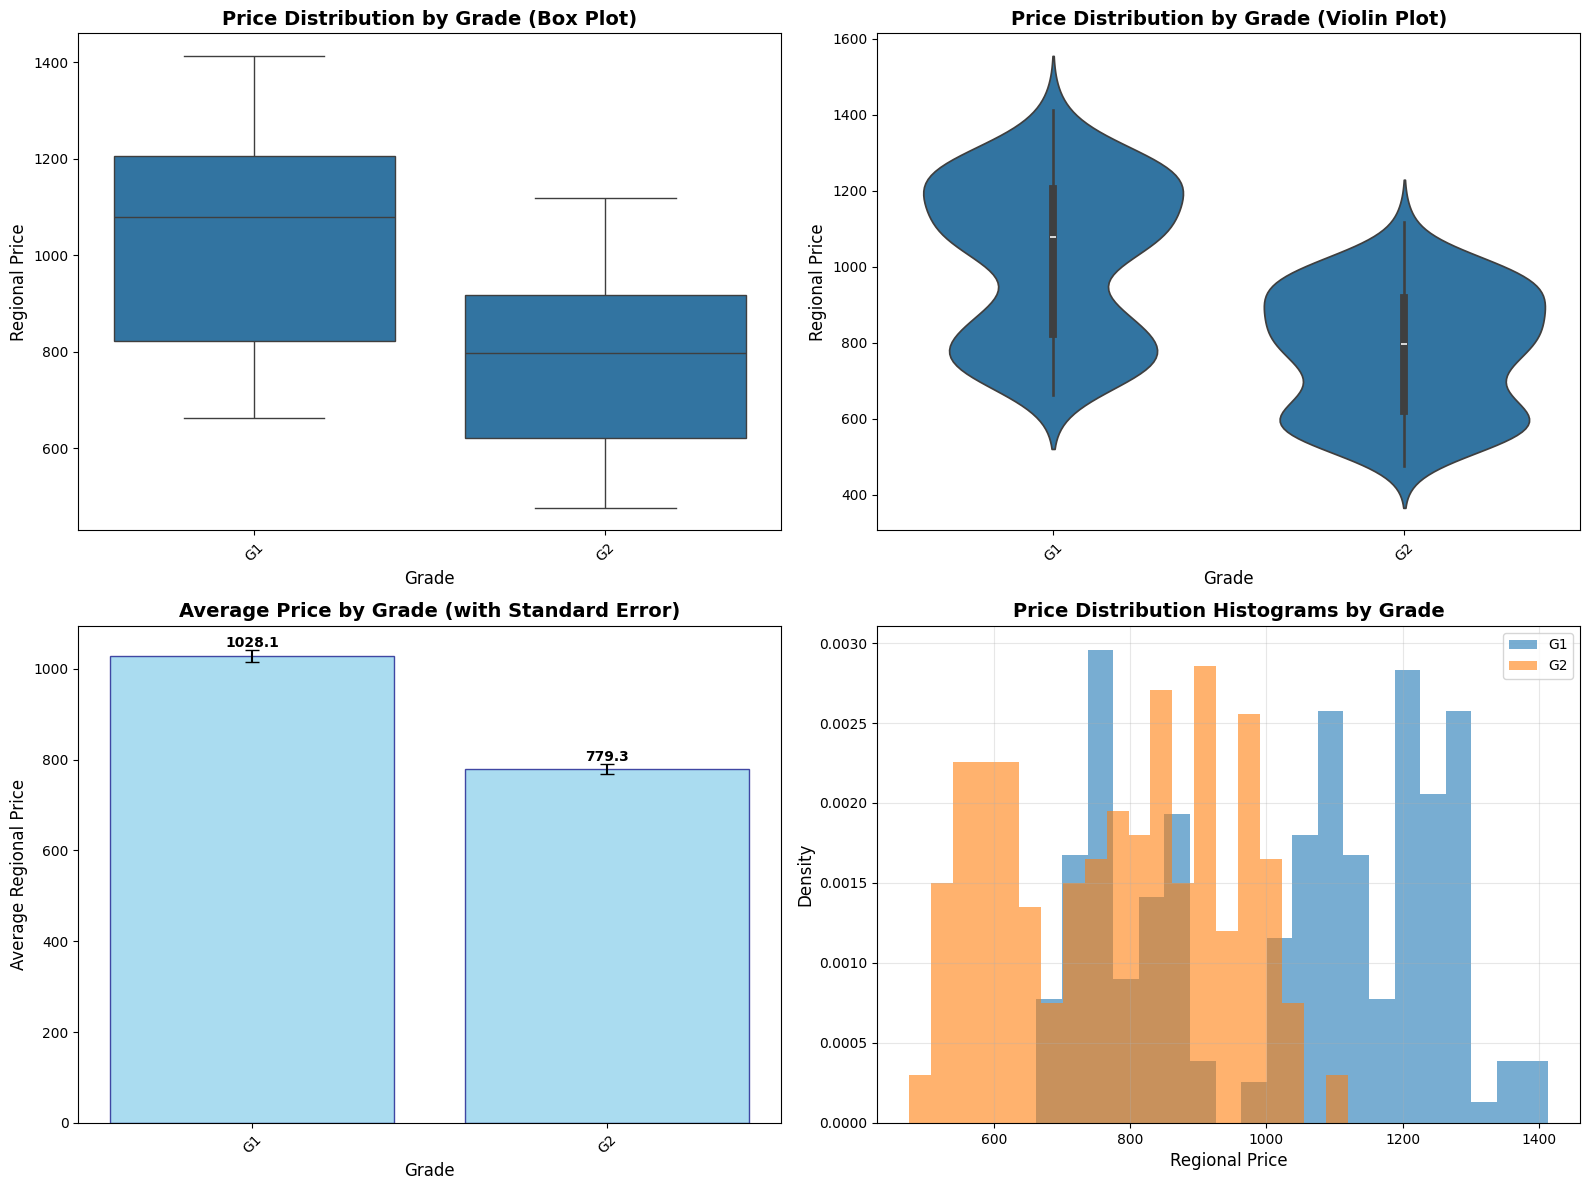


Price Distribution Summary by Grade:
       count     mean     std     min     25%      50%      75%      max
Grade                                                                   
G1     207.0  1028.06  205.73  662.70  822.24  1079.58  1205.05  1413.59
G2     207.0   779.26  160.01  476.19  621.32   796.80   917.79  1119.36


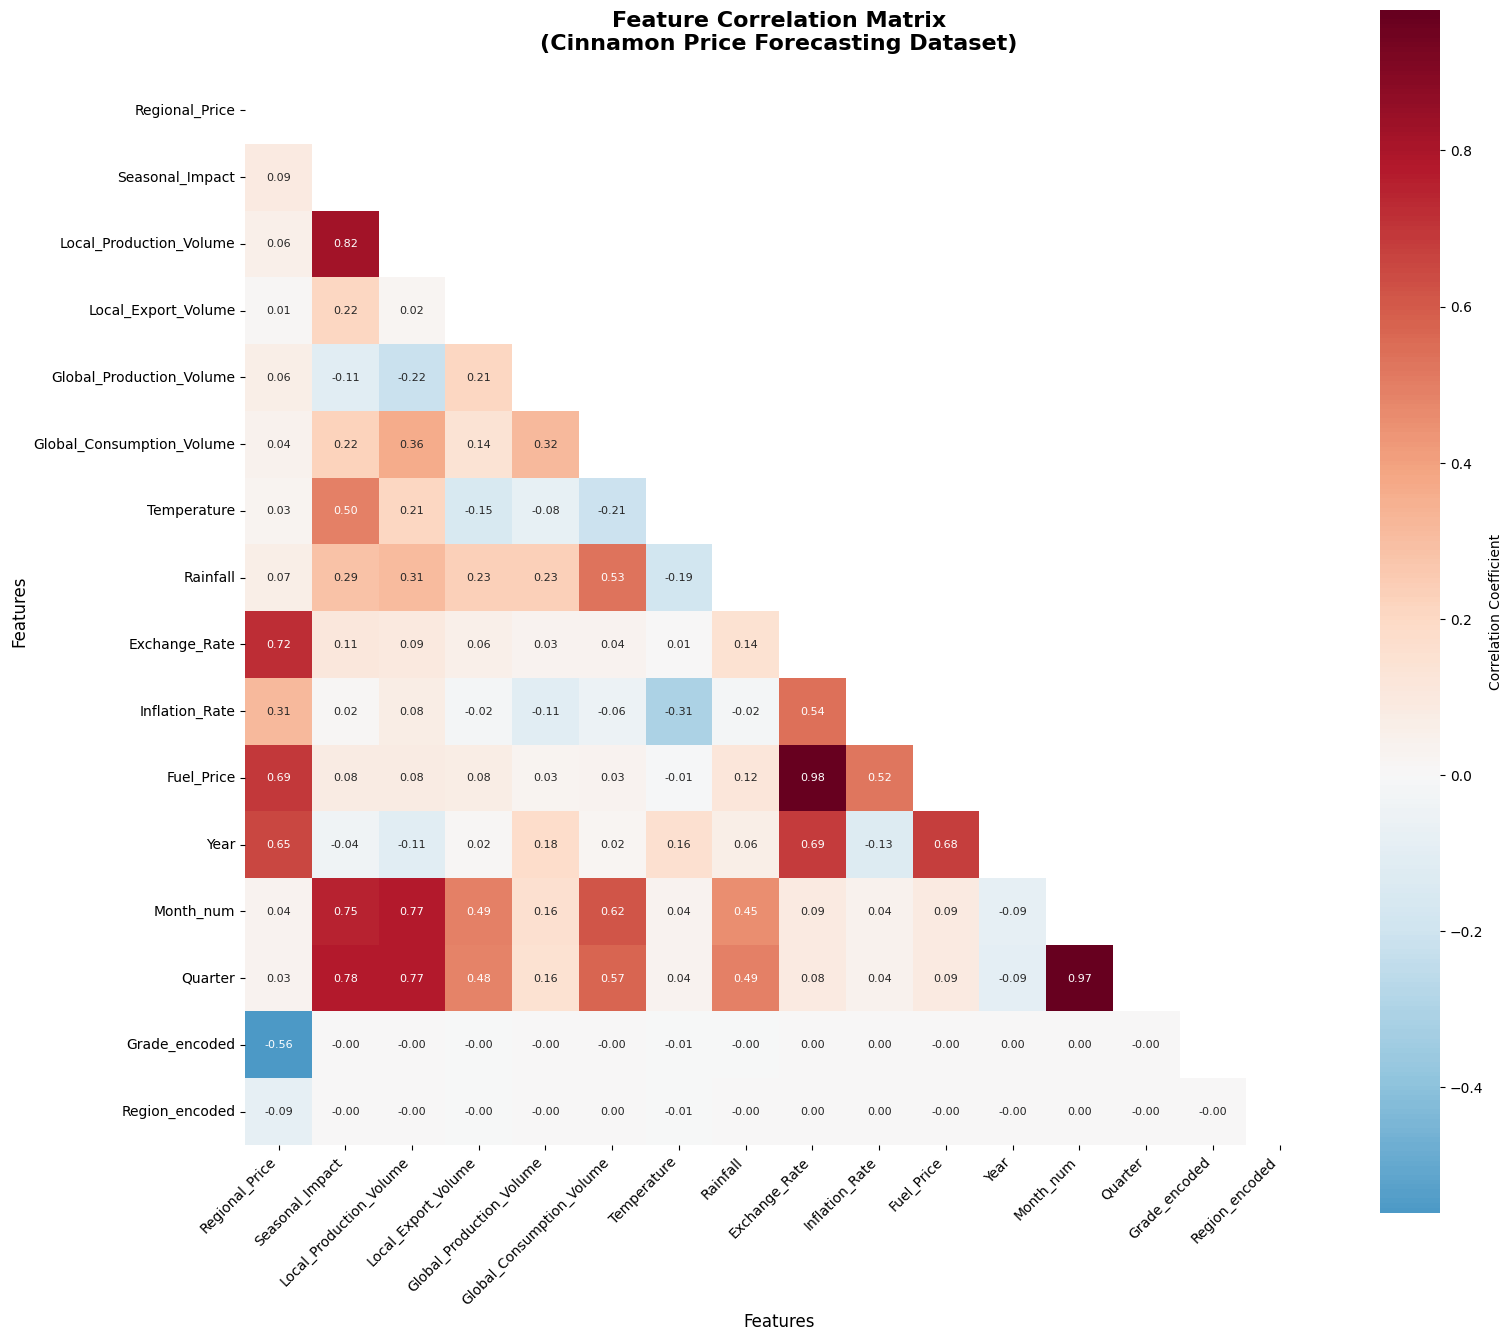


Highly Correlated Feature Pairs (|correlation| > 0.7):
Exchange_Rate ↔ Fuel_Price: 0.980
Month_num ↔ Quarter: 0.971
Seasonal_Impact ↔ Local_Production_Volume: 0.819
Seasonal_Impact ↔ Quarter: 0.777
Local_Production_Volume ↔ Quarter: 0.772
Local_Production_Volume ↔ Month_num: 0.772
Seasonal_Impact ↔ Month_num: 0.754
Regional_Price ↔ Exchange_Rate: 0.723

🤖 Step 3: Training LSTM model...
Preparing sequences...


[I 2025-10-27 11:02:53,176] A new study created in memory with name: no-name-8326fdd1-dfce-4b87-b9b8-7ec8065eeaed


Total sequences created: 342
Created 342 sequences with shape (342, 12, 36)
Scaling features...
Training set shape: X=(204, 12, 36), y=(204,)
Validation set shape: X=(69, 12, 36), y=(69,)
Test set shape: X=(69, 12, 36), y=(69,)

🔧 Performing hyperparameter tuning using optuna method...

🚀 Starting Hyperparameter Tuning using OPTUNA method...

🎯 Starting Optuna Hyperparameter Tuning...


Best trial: 0. Best value: 0.0232583:   2%|▏         | 1/50 [01:02<51:08, 62.63s/it]

[I 2025-10-27 11:03:55,785] Trial 0 finished with value: 0.023258289322257042 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.00048569384614364017, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 0 with value: 0.023258289322257042.


Best trial: 0. Best value: 0.0232583:   4%|▍         | 2/50 [02:18<56:09, 70.19s/it]

[I 2025-10-27 11:05:11,265] Trial 1 finished with value: 0.08091232925653458 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0013311550853775378, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 0 with value: 0.023258289322257042.


Best trial: 0. Best value: 0.0232583:   6%|▌         | 3/50 [03:34<57:08, 72.95s/it]

[I 2025-10-27 11:06:27,503] Trial 2 finished with value: 0.026647701859474182 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.00013155239285253252, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 0.023258289322257042.


Best trial: 3. Best value: 0.01753:   8%|▊         | 4/50 [04:28<50:06, 65.36s/it]  

[I 2025-10-27 11:07:21,225] Trial 3 finished with value: 0.0175300482660532 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.0011767520774035177, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  10%|█         | 5/50 [05:17<44:43, 59.63s/it]

[I 2025-10-27 11:08:10,712] Trial 4 finished with value: 0.0246586836874485 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.4, 'dense_units': 16, 'learning_rate': 0.007157763239137804, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  12%|█▏        | 6/50 [06:43<50:22, 68.69s/it]

[I 2025-10-27 11:09:36,984] Trial 5 finished with value: 0.26044702529907227 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.000131450947485385, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  14%|█▍        | 7/50 [08:17<54:58, 76.70s/it]

[I 2025-10-27 11:11:10,181] Trial 6 finished with value: 0.051534492522478104 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0018979981915311216, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  16%|█▌        | 8/50 [09:46<56:34, 80.83s/it]

[I 2025-10-27 11:12:39,851] Trial 7 finished with value: 0.08488649874925613 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.5, 'dropout2': 0.5, 'dense_units': 64, 'learning_rate': 0.00265940573481172, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  18%|█▊        | 9/50 [11:18<57:30, 84.15s/it]

[I 2025-10-27 11:14:11,318] Trial 8 finished with value: 0.04420367255806923 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'dense_units': 128, 'learning_rate': 0.0016204057874578612, 'layer_type': 'GRU', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  20%|██        | 10/50 [12:12<50:00, 75.00s/it]

[I 2025-10-27 11:15:05,829] Trial 9 finished with value: 0.020684966817498207 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.5, 'dense_units': 32, 'learning_rate': 0.0003751030471474371, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  22%|██▏       | 11/50 [13:20<47:14, 72.68s/it]

[I 2025-10-27 11:16:13,229] Trial 10 finished with value: 0.02093658223748207 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 32, 'learning_rate': 0.006704142028946249, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  24%|██▍       | 12/50 [14:32<45:53, 72.46s/it]

[I 2025-10-27 11:17:25,205] Trial 11 finished with value: 0.023127490654587746 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.5, 'dense_units': 32, 'learning_rate': 0.0004660084428203043, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  26%|██▌       | 13/50 [15:17<39:41, 64.37s/it]

[I 2025-10-27 11:18:10,948] Trial 12 finished with value: 0.051827818155288696 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 32, 'learning_rate': 0.0005187907774283542, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  28%|██▊       | 14/50 [16:28<39:50, 66.40s/it]

[I 2025-10-27 11:19:22,047] Trial 13 finished with value: 0.025913918390870094 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.5, 'dense_units': 32, 'learning_rate': 0.00025115381299644393, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  30%|███       | 15/50 [17:30<37:52, 64.92s/it]

[I 2025-10-27 11:20:23,544] Trial 14 finished with value: 0.025612061843276024 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.0008266353525598005, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  32%|███▏      | 16/50 [18:34<36:34, 64.54s/it]

[I 2025-10-27 11:21:27,187] Trial 15 finished with value: 0.027983462437987328 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.5, 'dense_units': 32, 'learning_rate': 0.0008086552285203493, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  34%|███▍      | 17/50 [19:18<32:05, 58.36s/it]

[I 2025-10-27 11:22:11,166] Trial 16 finished with value: 0.018890539184212685 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.0034680977925855266, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 3. Best value: 0.01753:  36%|███▌      | 18/50 [20:14<30:46, 57.71s/it]

[I 2025-10-27 11:23:07,365] Trial 17 finished with value: 0.019552791491150856 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.003949679681564484, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 3 with value: 0.0175300482660532.


Best trial: 18. Best value: 0.016956:  38%|███▊      | 19/50 [21:15<30:23, 58.83s/it]

[I 2025-10-27 11:24:08,808] Trial 18 finished with value: 0.016955967992544174 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.0039736008828780275, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 18 with value: 0.016955967992544174.


Best trial: 18. Best value: 0.016956:  40%|████      | 20/50 [22:10<28:53, 57.79s/it]

[I 2025-10-27 11:25:04,163] Trial 19 finished with value: 0.020563609898090363 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.004132437710627287, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 18 with value: 0.016955967992544174.


Best trial: 18. Best value: 0.016956:  42%|████▏     | 21/50 [23:13<28:38, 59.25s/it]

[I 2025-10-27 11:26:06,845] Trial 20 finished with value: 0.018559062853455544 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.009813587620115997, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 18 with value: 0.016955967992544174.


Best trial: 18. Best value: 0.016956:  44%|████▍     | 22/50 [24:18<28:24, 60.88s/it]

[I 2025-10-27 11:27:11,510] Trial 21 finished with value: 0.01925584115087986 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.00969829402890027, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 18 with value: 0.016955967992544174.


Best trial: 18. Best value: 0.016956:  46%|████▌     | 23/50 [25:13<26:38, 59.22s/it]

[I 2025-10-27 11:28:06,854] Trial 22 finished with value: 0.017680281773209572 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.005813579419472719, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 18 with value: 0.016955967992544174.


Best trial: 18. Best value: 0.016956:  48%|████▊     | 24/50 [26:01<24:14, 55.93s/it]

[I 2025-10-27 11:28:55,116] Trial 23 finished with value: 0.019748356193304062 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.005179392231094785, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 18 with value: 0.016955967992544174.


Best trial: 18. Best value: 0.016956:  50%|█████     | 25/50 [26:45<21:43, 52.14s/it]

[I 2025-10-27 11:29:38,407] Trial 24 finished with value: 0.024875802919268608 and parameters: {'units1': 64, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.30000000000000004, 'dense_units': 16, 'learning_rate': 0.0023556021109000856, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 18 with value: 0.016955967992544174.


Best trial: 25. Best value: 0.0144357:  52%|█████▏    | 26/50 [28:06<24:22, 60.94s/it]

[I 2025-10-27 11:30:59,886] Trial 25 finished with value: 0.01443569827824831 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.4, 'dense_units': 64, 'learning_rate': 0.0011553204283620082, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.01443569827824831.


Best trial: 25. Best value: 0.0144357:  54%|█████▍    | 27/50 [29:19<24:40, 64.37s/it]

[I 2025-10-27 11:32:12,257] Trial 26 finished with value: 0.3330935537815094 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.1, 'dropout2': 0.5, 'dense_units': 64, 'learning_rate': 0.0011552483317636409, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 25 with value: 0.01443569827824831.


Best trial: 25. Best value: 0.0144357:  56%|█████▌    | 28/50 [30:40<25:26, 69.37s/it]

[I 2025-10-27 11:33:33,282] Trial 27 finished with value: 0.014933135360479355 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'dense_units': 64, 'learning_rate': 0.000964516136001453, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.01443569827824831.


Best trial: 25. Best value: 0.0144357:  58%|█████▊    | 29/50 [32:01<25:35, 73.11s/it]

[I 2025-10-27 11:34:55,146] Trial 28 finished with value: 0.014876808039844036 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 64, 'learning_rate': 0.0007220957423927717, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.01443569827824831.


Best trial: 25. Best value: 0.0144357:  60%|██████    | 30/50 [33:02<23:08, 69.44s/it]

[I 2025-10-27 11:35:55,997] Trial 29 finished with value: 0.015650682151317596 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0006715188179693046, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.01443569827824831.


Best trial: 25. Best value: 0.0144357:  62%|██████▏   | 31/50 [34:07<21:32, 68.05s/it]

[I 2025-10-27 11:37:00,801] Trial 30 finished with value: 0.03536035120487213 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 16, 'learning_rate': 0.0002697883642084202, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 25 with value: 0.01443569827824831.


Best trial: 31. Best value: 0.0140064:  64%|██████▍   | 32/50 [35:21<20:56, 69.78s/it]

[I 2025-10-27 11:38:14,642] Trial 31 finished with value: 0.014006368815898895 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0007452396817363845, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  66%|██████▌   | 33/50 [36:28<19:31, 68.91s/it]

[I 2025-10-27 11:39:21,507] Trial 32 finished with value: 0.015845442190766335 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0006059918916271999, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  68%|██████▊   | 34/50 [37:43<18:50, 70.64s/it]

[I 2025-10-27 11:40:36,195] Trial 33 finished with value: 0.01422778982669115 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0009596339948292923, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  70%|███████   | 35/50 [39:14<19:14, 76.95s/it]

[I 2025-10-27 11:42:07,848] Trial 34 finished with value: 0.017250312492251396 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00151882940113254, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  72%|███████▏  | 36/50 [40:28<17:42, 75.91s/it]

[I 2025-10-27 11:43:21,351] Trial 35 finished with value: 0.02295478992164135 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0003502997917022949, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  74%|███████▍  | 37/50 [41:43<16:26, 75.85s/it]

[I 2025-10-27 11:44:37,069] Trial 36 finished with value: 0.11707305908203125 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0010383348458588675, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  76%|███████▌  | 38/50 [43:01<15:17, 76.42s/it]

[I 2025-10-27 11:45:54,803] Trial 37 finished with value: 0.014814423397183418 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0007524014363920236, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  78%|███████▊  | 39/50 [44:13<13:44, 75.00s/it]

[I 2025-10-27 11:47:06,487] Trial 38 finished with value: 0.10553286224603653 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.001307304235541809, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  80%|████████  | 40/50 [45:23<12:16, 73.66s/it]

[I 2025-10-27 11:48:17,016] Trial 39 finished with value: 0.015891961753368378 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0020293362492794743, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  82%|████████▏ | 41/50 [46:41<11:13, 74.80s/it]

[I 2025-10-27 11:49:34,468] Trial 40 finished with value: 0.22055651247501373 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.00020073685436355077, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  84%|████████▍ | 42/50 [47:58<10:04, 75.51s/it]

[I 2025-10-27 11:50:51,635] Trial 41 finished with value: 0.016289982944726944 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0007069037707632564, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  86%|████████▌ | 43/50 [49:03<08:25, 72.27s/it]

[I 2025-10-27 11:51:56,344] Trial 42 finished with value: 0.01808636263012886 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0004401623559284985, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  88%|████████▊ | 44/50 [50:18<07:19, 73.25s/it]

[I 2025-10-27 11:53:11,889] Trial 43 finished with value: 0.01688050664961338 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0008619356754343062, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  90%|█████████ | 45/50 [51:24<05:55, 71.07s/it]

[I 2025-10-27 11:54:17,863] Trial 44 finished with value: 0.01732386276125908 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.5, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0005745432770235349, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  92%|█████████▏| 46/50 [52:36<04:45, 71.36s/it]

[I 2025-10-27 11:55:29,919] Trial 45 finished with value: 0.01811271905899048 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0015945311245078564, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  94%|█████████▍| 47/50 [54:01<03:46, 75.45s/it]

[I 2025-10-27 11:56:54,907] Trial 46 finished with value: 0.016977449879050255 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0012495224380813727, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  96%|█████████▌| 48/50 [55:05<02:23, 71.99s/it]

[I 2025-10-27 11:57:58,804] Trial 47 finished with value: 0.01850389689207077 and parameters: {'units1': 256, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0003847034547125599, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064:  98%|█████████▊| 49/50 [56:43<01:19, 79.67s/it]

[I 2025-10-27 11:59:36,410] Trial 48 finished with value: 0.018513213843107224 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.1, 'dense_units': 16, 'learning_rate': 0.0007390184029320455, 'layer_type': 'GRU', 'use_batch_norm': False, 'optimizer': 'rmsprop'}. Best is trial 31 with value: 0.014006368815898895.


Best trial: 31. Best value: 0.0140064: 100%|██████████| 50/50 [57:49<00:00, 69.38s/it]


[I 2025-10-27 12:00:42,406] Trial 49 finished with value: 0.07377218455076218 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.5, 'dropout2': 0.2, 'dense_units': 128, 'learning_rate': 0.0010597118012756626, 'layer_type': 'LSTM', 'use_batch_norm': True, 'optimizer': 'adam'}. Best is trial 31 with value: 0.014006368815898895.

🎉 Optuna Tuning Complete!
Best validation loss: 0.014006
Best parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.4, 'dropout2': 0.1, 'dense_units': 128, 'learning_rate': 0.0007452396817363845, 'layer_type': 'LSTM', 'use_batch_norm': False, 'optimizer': 'adam'}

📊 Hyperparameter Tuning Results:
Best validation loss: 0.014006
Best parameters:
  units1: 256
  units2: 128
  dropout1: 0.4
  dropout2: 0.1
  dense_units: 128
  learning_rate: 0.0007452396817363845
  layer_type: LSTM
  use_batch_norm: False
  optimizer: adam

Building final model with optimized parameters...

📋 Final Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 256)        │       300,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513,793 (1.96 MB)

 Trainable params: 513,793 (1.96 MB)

 Non-trainable params: 0 (0.00 B)


Training final model...
Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 454ms/step - loss: 0.5311 - mae: 0.5555 - val_loss: 0.2943 - val_mae: 0.4144 - learning_rate: 7.4524e-04
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.2016 - mae: 0.3494 - val_loss: 0.1175 - val_mae: 0.2451 - learning_rate: 7.4524e-04
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0962 - mae: 0.2469 - val_loss: 0.0714 - val_mae: 0.1929 - learning_rate: 7.4524e-04
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0748 - mae: 0.2197 - val_loss: 0.0587 - val_mae: 0.1650 - learning_rate: 7.4524e-04
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - loss: 0.0450 - mae: 0.1645 - val_loss: 0.0676 - val_mae: 0.1993 - learning_rate: 7.4524e-04
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 0.0392 - mae: 0.1609 - val_loss: 0.0387 - val_mae: 0.1495 - learning_rate: 7.4524e-04
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - loss: 0.0308 - mae: 0.1399 - val_loss: 0.0402 - val

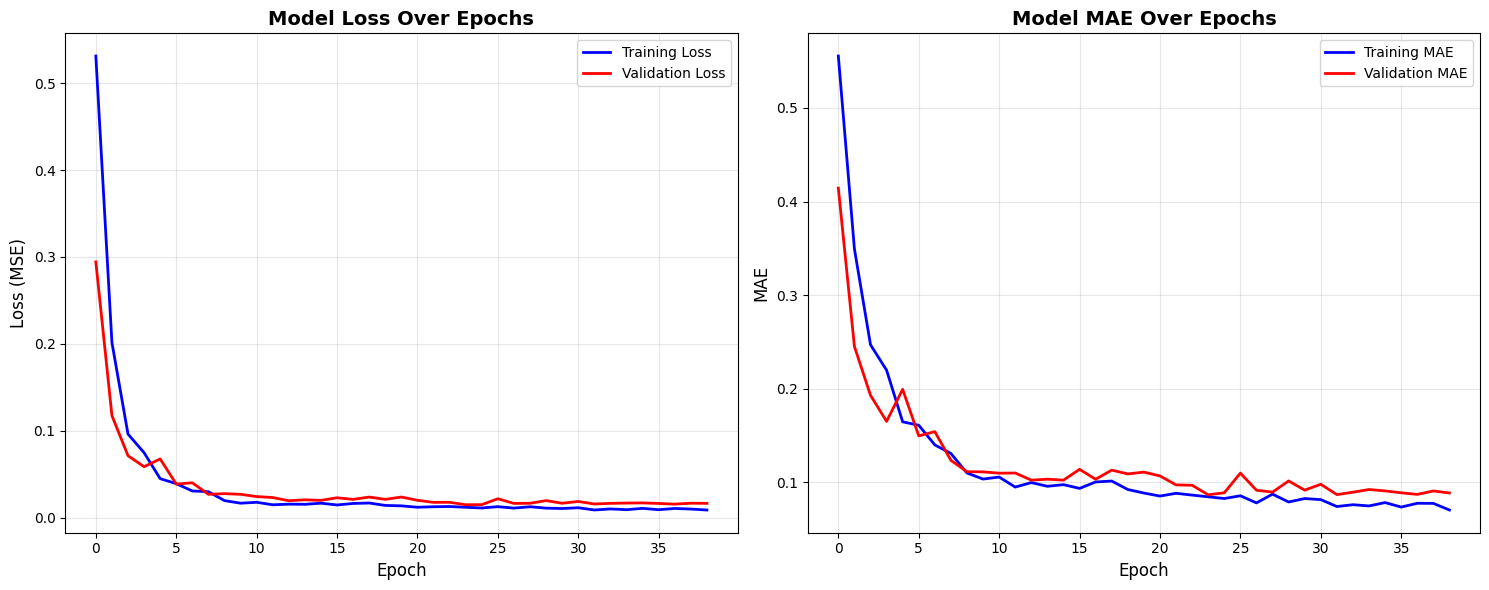


Final Training Metrics:
Training Loss: 0.0089
Validation Loss: 0.0165
Training MAE: 0.0703
Validation MAE: 0.0885

Evaluating final model on test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 483ms/step

🎯 Final Model Performance on Test Set:
MAE: 18.07
RMSE: 24.72
R²: 0.9887

💾 Step 4: Saving trained model...

💾 Saving model to: cinnamon_models/Quillings\cinnamon_model_20251027_120207
✅ Keras model saved: lstm_model.keras
✅ Scalers saved: scalers.pkl
✅ Label encoders saved: label_encoders.pkl
✅ Model configuration saved: model_config.json

🎉 Model successfully saved to: cinnamon_models/Quillings\cinnamon_model_20251027_120207

📊 Saved Model Summary:
  • Performance: MAE=18.07, RMSE=24.72, R²=0.9887
  • Hyperparameter tuning: optuna method used
  • Best parameters found and applied
  • Training epochs: 39
  • Total parameters: 513,793
✅ Model saved at: cinnamon_models/Quillings\cinnamon_model_20251027_120207

🔮 Step 5: Generating sample forecasts...
Available grades: ['G1' 'G2']
Available region

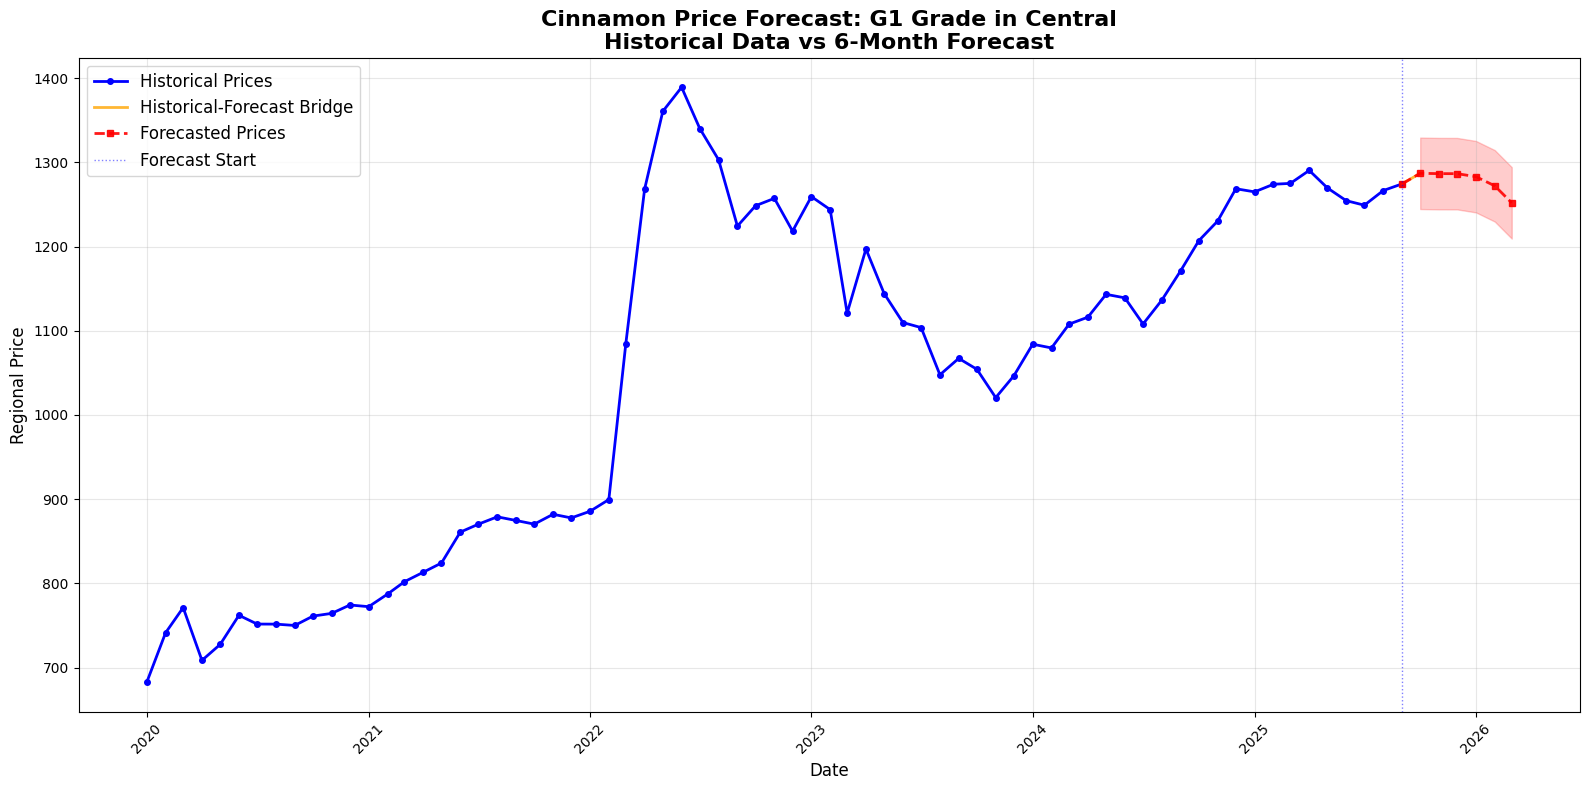


G1 Grade Forecast for Central:
Month  1 (2025-10): LKR  1286.95
Month  2 (2025-11): LKR  1286.57
Month  3 (2025-12): LKR  1286.54
Month  4 (2026-01): LKR  1282.95
Month  5 (2026-02): LKR  1272.07
Month  6 (2026-03): LKR  1251.85

Forecast Statistics:
Average Forecast Price: LKR 1277.82
Price Range: LKR 1251.85 - LKR 1286.95
Overall Trend: decreasing by LKR 5.85 per month

🎯 TRAINING SUMMARY
✅ Hyperparameter tuning: optuna method used
🏆 Best parameters found:
   • units1: 256
   • units2: 128
   • dropout1: 0.4
   • dropout2: 0.1
   • dense_units: 128
   • learning_rate: 0.0007452396817363845
   • layer_type: LSTM
   • use_batch_norm: False
   • optimizer: adam

📊 Final Model Performance:
   • MAE: 18.0677
   • RMSE: 24.7184
   • R²: 0.9887
   • Training epochs: 39

✅ Training complete! Model is ready for forecasting.


In [97]:
if __name__ == "__main__":
    print("=" * 80)
    print("🚀 CINNAMON PRICE FORECASTING WITH LSTM")
    print("=" * 80)
    

    DATA_PATH = 'C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Quillings_Dataset.csv'  
    USE_HYPERPARAMETER_TUNING = True  
    TUNING_METHOD = 'optuna'  # Options: 'optuna', 'random'
    N_TUNING_TRIALS = 50
    
    # Step 1: Load and prepare data
    print("\n📊 Step 1: Loading and preparing data...")
    df = load_and_prepare_data(DATA_PATH)
    print(f"✅ Data loaded successfully! Shape: {df.shape}")
    
    # Step 2: Visualizations
    print("\n📈 Step 2: Generating visualizations...")
    plot_price_distribution_by_grade(df)
    plot_feature_correlation_matrix(df)
    
    # Step 3: Train model
    print("\n🤖 Step 3: Training LSTM model...")
    model, history, metrics = train_model(
        df, 
        use_tuning=USE_HYPERPARAMETER_TUNING,
        tuning_method=TUNING_METHOD,
        n_tuning_trials=N_TUNING_TRIALS
    )
    
    # Step 4: Save model
    print("\n💾 Step 4: Saving trained model...")
    saved_model_path = save_model(model, metrics)
    print(f"✅ Model saved at: {saved_model_path}")
    
    # Step 5: Generate forecasts
    print("\n🔮 Step 5: Generating sample forecasts...")
    available_grades = df['Grade'].unique()
    available_regions = df['Region'].unique()
    
    print(f"Available grades: {available_grades}")
    print(f"Available regions: {available_regions}")
    
    # Generate forecast for first combination
    if len(available_grades) > 0 and len(available_regions) > 0:
        grade_to_forecast = available_grades[0]
        region_to_forecast = available_regions[0]
        
        print(f"\n📈 Generating 6-month forecast for {grade_to_forecast} in {region_to_forecast}...")
        forecasts, future_dates = plot_forecast_results(
            df, model, grade_to_forecast, region_to_forecast, months_ahead=6
        )
    
    # Print summary
    print("\n" + "=" * 80)
    print("🎯 TRAINING SUMMARY")
    print("=" * 80)
    
    if metrics.get('tuning_used'):
        print(f"✅ Hyperparameter tuning: {metrics['tuning_method']} method used")
        print(f"🏆 Best parameters found:")
        for key, value in metrics['best_params'].items():
            print(f"   • {key}: {value}")
    else:
        print("❌ Hyperparameter tuning was skipped - default parameters used")
    
    print(f"\n📊 Final Model Performance:")
    print(f"   • MAE: {metrics['mae']:.4f}")
    print(f"   • RMSE: {metrics['rmse']:.4f}")
    print(f"   • R²: {metrics['r2']:.4f}")
    print(f"   • Training epochs: {metrics['epochs_trained']}")
    
    print("\n✅ Training complete! Model is ready for forecasting.")
    print("=" * 80)

In [99]:
# Determine expected features (use TRAIN_FEATURE_COLS if X_train isn't available)
try:
	expected_features = X_train.columns
except NameError:
	# Fall back to predefined TRAIN_FEATURE_COLS from the notebook
	expected_features = TRAIN_FEATURE_COLS

# Convert to a set for fast comparison
expected_feature_set = set(expected_features)
print(f"Expected Features: {len(expected_feature_set)}")
print("Sample features:", list(expected_feature_set)[:10])

Expected Features: 36
Sample features: ['Rainfall_rolling_12', 'Month_num', 'Rainfall_rolling_3', 'Global_Production_Volume', 'Local_Export_Volume', 'Regional_Price_lag_12', 'Quarter', 'Grade_encoded', 'Rainfall_lag_1', 'Rainfall_lag_12']
